# spirograph wheel

```
# This is formatted as code
```

l [link text](`https://`)curve

*<<< check out other demo models [here](https://github.com/FullControlXYZ/fullcontrol/tree/master/models/README.md) >>>*
  
press ctrl+F9 to run all cells in this notebook, or press shift+enter to run each cell sequentially

if you change one of the code cells, make sure you run it and all subsequent cells again (in order)

*this document is a jupyter notebook - if they're new to you, check out how they work: [link](https://www.google.com/search?q=ipynb+tutorial), [link](https://jupyter.org/try-jupyter/retro/notebooks/?path=notebooks/Intro.ipynb), [link](https://colab.research.google.com/)*
### be patient :)

the next code cell may take a while because running it causes several things to happen:
- connect to a google colab server -> download the fullcontrol code -> install the fullcontrol code

check out [other tutorials](https://github.com/FullControlXYZ/fullcontrol/blob/master/docs/README.md) to understand the python code for the FullControl design

In [1]:
if 'google.colab' in str(get_ipython()):
  try:
    import fullcontrol as fc
  except Exception as e:
    print (e)
    print('Attempting to install missing packages. Please wait ...')
    !pip install git+https://github.com/FullControlXYZ/fullcontrol --quiet
    import fullcontrol as fc
  from google.colab import files
from math import cos, tau
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def ift(t,a,f=None):
  n=len(a)
  n_2=n//2
  if f is None:
    f=np.roll(np.arange(-n_2,n_2),n_2)
  f=f.reshape((-1,1))
  return np.sum(a.reshape((-1,1))*np.exp(1j*2*np.pi*f*t),axis=0)/n


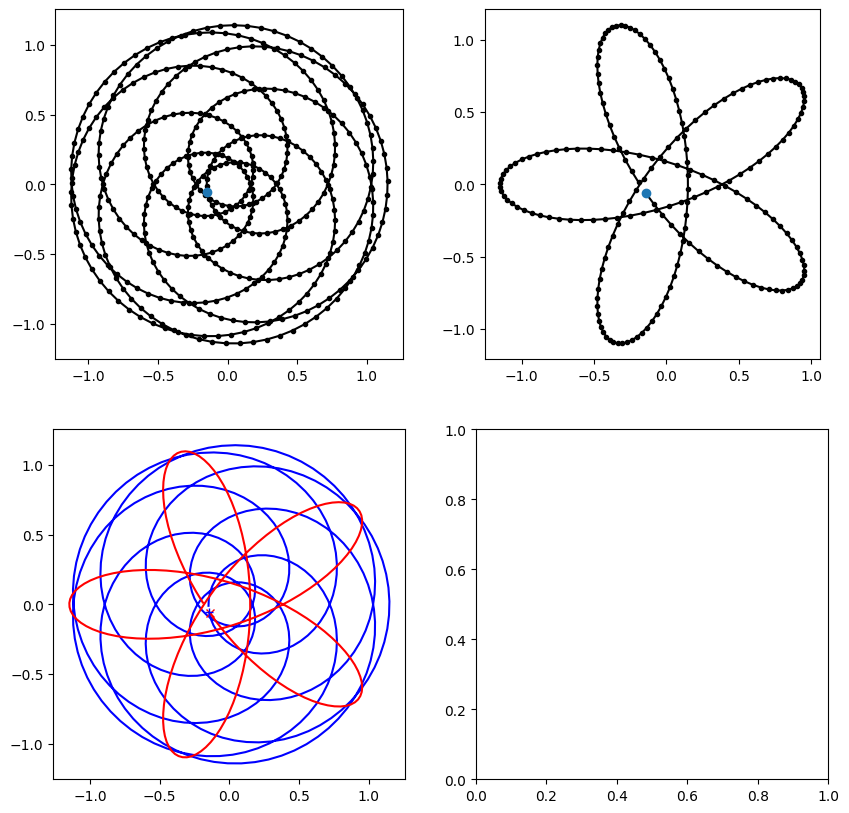

In [3]:
x1=ift(np.arange(0,1,1/500),np.array([1*1j**(0.35/9),1.3*1j**(2+0.35/4)]),np.array([4,9]))
x2=ift(np.arange(0,1,1/200),np.array([1j**(+2-4.76/3),1.3*1j**(0+4.76/2)]),np.array([-2,3]))
fig,((ax1,ax2),(ax3,_))=plt.subplots(2,2,figsize=(10,10))
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax3.set_aspect('equal')
ax1.plot(x1.real,x1.imag,'k.-');
ax1.plot(x1[0].real,x1[0].imag,'o')
ax2.plot(x2.real,x2.imag,'k.-')
ax2.plot(x2[0].real,x2[0].imag,'o')
ax3.plot(x1.real,x1.imag,'b-');
ax3.plot(x1[0].real,x1[0].imag,'b+',zorder=7)
ax3.plot(x2.real,x2.imag,'r-')
ax3.plot(x2[0].real,x2[0].imag,'rx',zorder=5)
x=np.concatenate((x1,x2))

In [4]:
# create design steps

# print part:
steps=[]
scale=10
hl=0.2
n=len(x)
dzdj=hl/n
j=0
zt=5
z=0
steps.append(fc.Extruder(on=False))
steps.extend(fc.travel_to(fc.Point(x=0,y=0,z=0)))
steps.extend(fc.travel_to(fc.Point(x=x[-1].real*scale,y=x[-1].imag*scale,z=0)))
steps.append(fc.Extruder(on=True))
old_eh=-1
while z<zt+hl:
  j=(j+1)%n
  z+=dzdj
  p=x[j]
  eh=min(z,hl,zt-(z-hl))
  if abs(eh-old_eh)>0.01:
    steps.append(fc.ExtrusionGeometry(area_model='rectangle',width=0.5,height=eh))
    old_eh=eh
 #   print(f'{z=:0.3f}, {eh=:0.3f}')
  steps.append(fc.Point(x=p.real*scale,y=p.imag*scale,z=min(z,zt)))
steps.append(fc.Extruder(on=False))
steps.extend(fc.travel_to(fc.Point(x=0,y=0)))
# offset the whole procedure. z dictates the gap between the nozzle and the bed for the first layer, assuming the model was designed with a first layer z-position of 0
steps = fc.move(steps,fc.Point(x=0,y=0,z=0.0))

In [5]:
# add annotations and plot
EW=0.5
EH=0.2
annotations = []
#annotations.append(fc.PlotAnnotation(point=steps[0], label = "Start"))
#annotations.append(fc.PlotAnnotation(point=steps[-1], label = "End"))
fc.transform(steps + annotations, 'plot', fc.PlotControls(color_type='print_sequence' ,initialization_data={'extrusion_width': EW, 'extrusion_height': EH}))

Output hidden; open in https://colab.research.google.com to view.